# Precision-associated metrics

Down below is the comparison of the following metrics which are different variants of average precision score:
- pr-auc (area under PR curve with trapezoidal interpolation)
- average precision score (area under PR curve with rectangular interpolation)
- area under PR curve with right-maximum interpolation
- area under 11-points interpolated PR curve
- average precision that is used in retrieval

## Preparations

### Load Data

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

X, y = load_breast_cancer(return_X_y=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, train_size=.9)
print(X_train.shape, X_val.shape)

(512, 30) (57, 30)


### Train Model

In [2]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l1', solver='saga').fit(X_train, y_train)
y_pred = model.predict_proba(X_val)

/home/ilya/repos/object-detection/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Calculating Metrics

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [4]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_pred[:, 1])

### trapezoidal interpolation

$$
\sum_{i=1}^{n-1}{\text{Precision}_{i+1}+\text{Precision}_{i}\over 2}(\text{Recall}_{i+1}-\text{Recall}_{i})
$$

pr auc = 0.85848


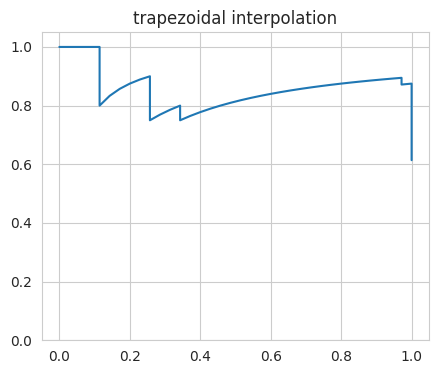

In [5]:
from sklearn.metrics import auc

pr_auc = auc(recall, precision)

plt.figure(figsize=(5,4))
plt.plot(recall, precision)
plt.ylim([0,1.05])
print(f'pr auc = {pr_auc:.5f}')
plt.title('trapezoidal interpolation')
plt.show()

### constant interpolation

$$
\sum_{i=1}^{n}\text{Precision}_{i}(\text{Recall}_i-\text{Recall}_{i-1})
$$

In [6]:
import numpy as np

def tolist(x, y) -> tuple[list, list]:
    assert len(x) == len(y)
    if isinstance(x, np.ndarray):
        x = x.tolist()
    if isinstance(y, np.ndarray):
        y = y.tolist()
    return x, y

def const_interp_auc(r, p):
    r, p = tolist(r, p)
    r = r[::-1]
    p = p[::-1]
    r = [0] + r
    return sum((r[i+1] - r[i]) * p[i] for i in range(len(p)))

def const_interp(r, p):
    r, p = tolist(r, p)
    res_r, res_p = [], []
    for i in range(1, len(r)):
        if p[i] < p[i-1]:
            res_r.append(r[i])
            res_p.append(p[i-1])
        res_r.append(r[i])
        res_p.append(p[i])
    return res_r, res_p

avg_prec=0.86273
avg_prec2=0.86273
avg_prec3=0.86273


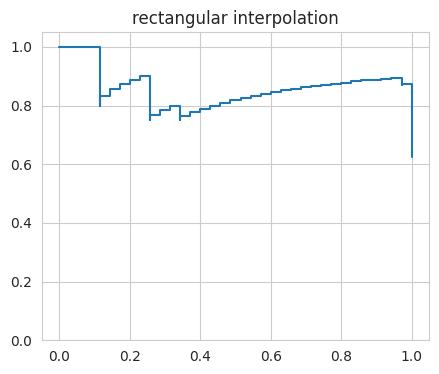

In [7]:
from sklearn.metrics import average_precision_score

avg_prec = average_precision_score(y_val, y_pred[:, 1])
print(f'{avg_prec=:.5f}')

avg_prec2 = const_interp_auc(recall, precision)
print(f'{avg_prec2=:.5f}')

x, y = const_interp(recall, precision)
avg_prec3 = auc(x, y)
print(f'{avg_prec3=:.5f}')

plt.figure(figsize=(5,4))
plt.plot(x, y)
plt.ylim([0,1.05])
plt.title('rectangular interpolation')
plt.show()

### maximum interpolation

$$
\sum_{i=1}^{n}\left[\max_{j\geqslant i}\text{Precision}_{j}\right](\text{Recall}_i-\text{Recall}_{i-1})
$$

In [8]:
def max_interp_auc(r, p):
    r, p = tolist(r, p)
    r = r[::-1]
    p = p[::-1]
    r = [0] + r
    return sum((r[i+1] - r[i]) * max(p[i:]) for i in range(len(p)))

def max_interp(x, y):
    x, y = tolist(x, y)
    res_x, res_y = [], []
    cur_max = y[0]
    for i in range(1, len(x)):
        cur_max = max(cur_max, y[i])
        res_x.append(x[i])
        res_y.append(cur_max)
    return res_x, res_y

avg_prec=0.90695
avg_prec1=0.90695


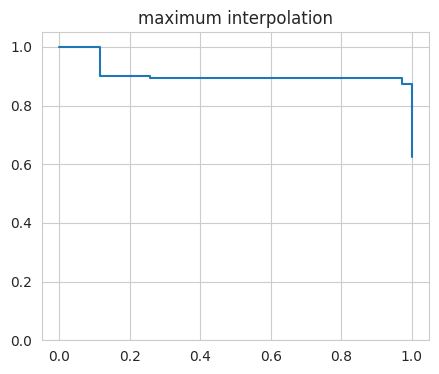

In [9]:
avg_prec = max_interp_auc(recall, precision)
print(f'{avg_prec=:.5f}')

x, y = max_interp(recall, precision)
avg_prec1 = auc(x, y)
print(f'{avg_prec1=:.5f}')

plt.figure(figsize=(5,4))
plt.plot(x, y)
plt.ylim([0,1.05])
plt.title('maximum interpolation')
plt.show()

### 11-point interpolation

In [10]:
from bisect import bisect_right

def elev_point_interp_auc(r, p):
    return auc(*elev_point_interp(r, p))

def elev_point_interp(r, p):
    r, p = tolist(r, p)
    r_old = r[::-1]
    p_old = p[::-1]
    r_new = list(i / 10 for i in range(11))
    p_new = [p_old[bisect_right(r_old, r)-1] for r in r_new]
    return r_new, p_new

avg_prec=0.84964


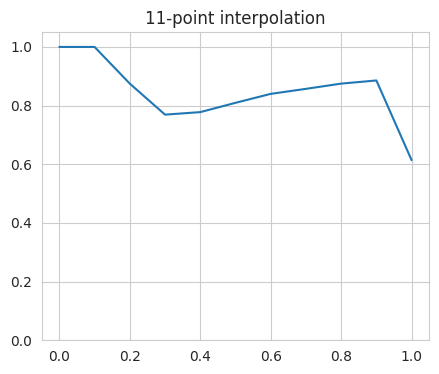

In [11]:
avg_prec = elev_point_interp_auc(recall, precision)
print(f'{avg_prec=:.5f}')

x, y = elev_point_interp(recall, precision)

plt.figure(figsize=(5,4))
plt.plot(x, y)
plt.ylim([0,1.05])
plt.title('11-point interpolation')
plt.show()

### (mean) average precision

AP is calculated as the following:
$$
\text{AP}=\sum_{i=1}^\ell{[y_{(i)}=1]\over\sum_{j=1}^\ell [y_j=1]}\text{Precision}@i,
$$
where ${(i)}$ is the sorting defined by the predicted ranks.

This one is equivalent to the area under the rectangularly interpolated PR curve, because $\text{Recall}_i-\text{Recall}_{i-1}={[y_{(i)}=1]/\sum_{j=1}^\ell [y_j=1]}$ and $\text{Precision}@i=\text{Precision}_i$.

### (mean) average precision @ k

AP@k is equivalent to AP over the set of top k retrieved ranked documents:
$$
\text{AP}@k=\sum_{i=1}^k{[y_{(i)}=1]\over\sum_{j=1}^k [y_{(j)}=1]}\text{Precision}@i,
$$